Config settings:
N: 10
T_train_val: 10000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
patience_epochs: 6
min_delta: 0.01
mode: min
factor: 0.1
patience_lr: 2
min_lr: 1e-06
threshold: 0.01
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 64
    num_layers: 4
gat_config:
    hidden_size: 32
    num_heads: 8
    num_get_layers: 3
gnn_config: GNNConfig(hidden_size=32, num_layers=3)
--------------------------------------------------
load_iid.shape: (10, 11000)
load_iid.type: <class 'numpy.ndarray'>
load_ar1.shape: (10, 11000)
load_ar1.type: <class 'numpy.ndarray'>
data.shape: (10, 11000)
data.type: <class 'numpy.ndarray'>
train_val_data.shape: (10, 10000)
train_val_data.type: <class 'numpy.ndarray'>
test_data.shape: (10, 1000)
test_data.type: <class 'numpy.ndarray'>
train_sets

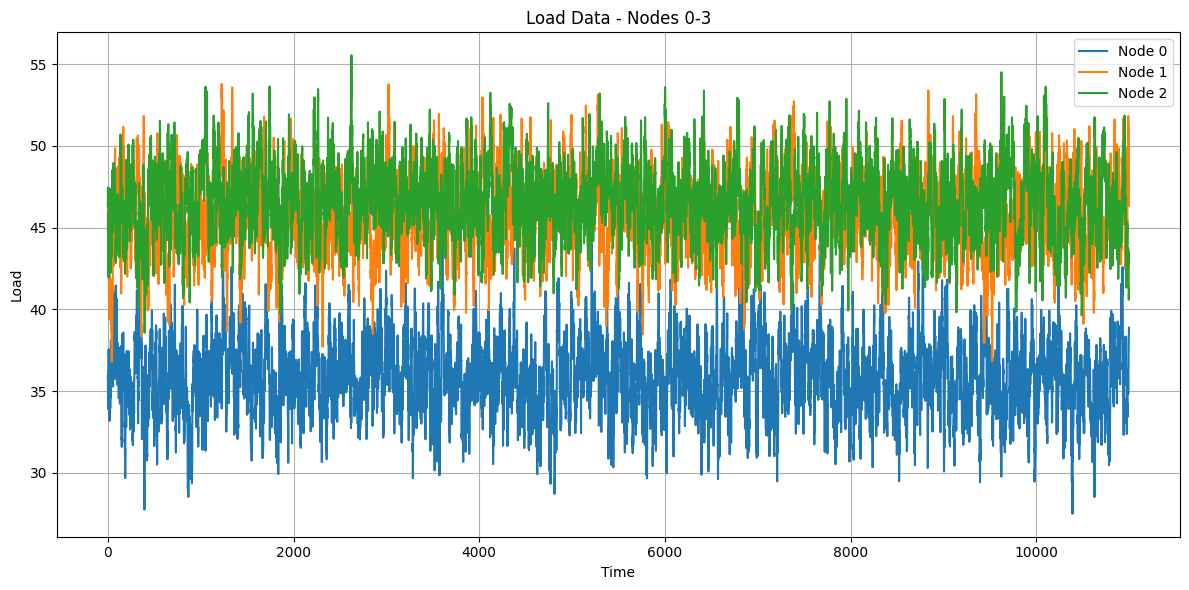

In [3]:
from Config_Data import Config, DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, GNNConfig,DataGenerate, DataManage
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

config = Config(
    N=10,
    T_train_val=10000,
    T_test=1000,
    data_type='ar1',

    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001,
    num_epochs=100,
    num_workers=24,
    device=device,
    mix_precision=True if device == 'cuda' else False,

    patience_epochs=6,
    min_delta=1e-2,

    mode='min',
    factor=0.1,
    patience_lr=2,
    min_lr=1e-6,
    threshold=1e-2,

    dg_config=DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    ar_config=ARConfig(order=5),
    lstm_config=LSTMConfig(hidden_size=64, num_layers=4),
    gat_config=GATConfig(hidden_size=32, num_heads=8, num_gat_layers=3),
    gnn_config=GNNConfig(hidden_size=32, num_layers=3)
)
config.print_config_info()

RE_GENERATE_DATA = False

if RE_GENERATE_DATA:
    data_generate = DataGenerate(config)

data_manage = DataManage(config)
data = data_manage.data

data_manage.plot_range_data(data[:3, :], start=0, end=len(data[0]), title='Load Data')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim.lr_scheduler as lr_scheduler


In [9]:
class ModelExpert:
    def __init__(self, config, data_manage, type):
        self.config = config
        self.data_manage = data_manage
        
        self.type = type
        
        if self.type == 'LSTM':
            self.model = self.LSTMModel(
                input_size=self.config.input_size,
                hidden_size=self.config.lstm_config.hidden_size,
                output_size=self.config.output_size,
                num_layers=self.config.lstm_config.num_layers
            ).to(self.config.device)
        elif self.type == 'GNN':
            self.model = self.GNNModel(
                in_channels=self.config.input_size,
                hidden_size=self.config.gnn_config.hidden_size,
                out_channels=self.config.output_size,
                num_layers=self.config.gnn_config.num_layers,
                edge_index=self.data_manage.edge_index
            ).to(self.config.device)
        else:
            raise ValueError("Invalid model type. Must be 'LSTM' or 'GNN'.")
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

        # 初始化调度器
        self.scheduler = lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=self.config.mode,  # 'min' 表示监控的指标需要最小化
            factor=self.config.factor,  # 每次减少学习率的比例
            patience=self.config.patience_lr,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
            min_lr=self.config.min_lr,  # 学习率的下限
            threshold=config.threshold  # 用于衡量监控指标的阈值，小于该值表示改善不明显
        )
        
        
        # self.scheduler = lr_scheduler.ReduceLROnPlateau(
        #     self.optimizer,
        #     mode='min',  # 'min' 表示监控的指标需要最小化
        #     factor=0.1,  # 每次减少学习率的比例
        #     patience=2,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
        #     min_lr=1e-6,  # 学习率的下限
        #     threshold=1e-2  # 用于衡量监控指标的阈值，小于该值表示改善不明显
        # )

        self.predictions = None
        self.true_values = None

        # 用于记录损失和学习率的列表
        self.train_losses = []
        self.fine_tune_losses = []
        self.learning_rates = []
        self.fine_tune_learning_rates = []

        self.epochs_trained = 0  # 用于记录实际训练的 epoch 数

    class GNNModel(nn.Module):
        def __init__(self, in_channels, hidden_size, out_channels, num_layers, edge_index):
            super().__init__()
            self.get_layers = nn.ModuleList()
            
            self.edge_index = edge_index.to(config.device)
            
            self.conv1 = GCNConv(in_channels, hidden_size)
            for _ in range(num_layers - 2):
                self.get_layers.append(GCNConv(hidden_size, hidden_size))
            self.conv2 = GCNConv(hidden_size, out_channels)
            self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
            self.fc = torch.nn.Linear(out_channels, out_channels)
    
        def forward(self, x):
            x = x.to(config.device)
            
            batch_size, seq_len, num_nodes = x.size()
    
            # Apply GCNConv to each time step individually
            x = F.relu(self.conv1(x, self.edge_index))
            x = self.conv2(x, self.edge_index)
    
            # Pass the transformed features through GRU
            out, _ = self.rnn(x)
    
            # Use the last time step's output to predict the next time step's node values
            out = self.fc(out[:, -1, :])  # Shape [batch_size, num_nodes]
            return out
        

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.layer_norm = nn.LayerNorm(hidden_size)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))
            out = self.layer_norm(out[:, -1, :])
            out = F.relu(out)
            out = self.fc(out)
            return out

    # 定义早停机制类
    class EarlyStopping:
        def __init__(self, config):
            # patience: 当验证集损失连续 patience 次没有下降时，停止训练
            # min_delta: 最小的损失下降值，小于该值则不认为损失下降
            self.config = config
            
            self.patience = self.config.patience_epochs
            self.min_delta = self.config.min_delta
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
    
        def __call__(self, train_loss):
            if self.best_loss is None:
                self.best_loss = train_loss
            elif train_loss < self.best_loss - self.min_delta:
                self.best_loss = train_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True     

    def train(self):
        scaler = torch.amp.GradScaler(device=self.config.device) if self.config.mix_precision else None
        early_stopping = self.EarlyStopping(self.config)

        print(f'device: {torch.cuda.get_device_name() if self.config.device == "cuda" else "CPU"}')

        self.model.train()
        for epoch in tqdm(range(self.config.num_epochs), desc="Training"):
            train_cumulative_loss = 0.0  # 训练集累积损失
            
            for train, val in self.data_manage.dataloader:
                # 确保数据在 GPU 上，且异步加载
                train, val = train.to(self.config.device, non_blocking=True).float(), val.to(self.config.device, non_blocking=True).float()

                self.optimizer.zero_grad()  # 梯度清零

                if self.config.mix_precision:  # 混合精度训练
                    with torch.amp.autocast(device_type=self.config.device):
                        if self.type == 'LSTM':
                            pred = self.model(train)
                        elif self.type == 'GNN':
                            pred = self.model(train)  # TODO
                        loss = self.criterion(pred, val)

                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()

                else:
                    if self.type == 'LSTM':
                        pred = self.model(train)  # 前向传播
                    elif self.type == 'GNN':
                        pred = self.model(train)
                    loss = self.criterion(pred, val)
                        
                    loss.backward()  # 反向传播
                    self.optimizer.step()  # 更新参数

                train_cumulative_loss += loss.item()
                self.train_losses.append(loss.item())  # 记录单次损失

            # 在每个epoch结束时，计算验证集的平均损失
            train_avg_loss = train_cumulative_loss / len(self.data_manage.dataloader)

            # 早停机制
            early_stopping(train_avg_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
                break

            # 调度器更新
            self.scheduler.step(train_avg_loss)
            
            # print(f'Epoch [{epoch + 1}/{self.config.num_epochs}], Loss: {train_loss:.4f}')
            current_lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)  # 记录学习率
            # print(f'Current Learning Rate: {current_lr:.6f}')

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.config.num_epochs}], Ave_Loss: {train_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

                if torch.cuda.is_available():  # 释放GPU缓存
                    torch.cuda.empty_cache()

        self.epochs_trained = epoch + 1  # 记录训练的总 epoch 数
        print(f"Training finished after {self.epochs_trained} epochs.")
        print(f"average loss pre epoch: {train_avg_loss:.4f}")

    def predict_and_fine_tune(self):
        tune_cumulative_loss = 0.0  # 微调累积损失
        predictions = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)
        true_values = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)

        # 选择训练集的最后一部分数据作为输入
        input_data = self.data_manage.train_val_data[:, -self.config.seq_length:].T.unsqueeze(0).to(self.config.device)  #  shape: [1, seq_length, input_size], [1, 20, 10]

        #  测试数据集
        test_data = self.data_manage.test_data.to(self.config.device)  # 将测试数据转移到 GPU, shape: [T_test, output_size], [1000, 10]

        for i in tqdm(range(self.config.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # 模型保持在训练模式，以便进行微调
            if self.type == 'LSTM':
                pred = self.model(input_data)  # 预测
            elif self.type == 'GNN':
                pred = self.model(input_data)
                
            real_value = test_data[:, i].to(self.config.device)  # 真实值

            # predictions.append(pred.squeeze(0).detach().cpu().numpy())
            # # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
            # true_values.append(real_value.detach().cpu().numpy())

            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]
            true_values[i] = real_value  # 将真实值保存到 true_values, shape: [T_test, output_size], [1000, 10]

            loss = self.criterion(pred.squeeze(0), real_value)  # 计算损失
            tune_cumulative_loss += loss.item()  # 累加损失
            self.fine_tune_losses.append(loss.item())  # 记录单次损失
            
            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # 在每个epoch结束时，计算验证集的平均损失
            tune_avg_loss = tune_cumulative_loss / (i + 1)

            # 调度器更新（可选，基于微调期间的损失）
            self.scheduler.step(tune_avg_loss)
            current_lr = self.scheduler.get_last_lr()[0]
            self.fine_tune_learning_rates.append(current_lr)

            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.config.T_test}, Loss: {tune_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

        # 更新输入序列
            input_data = torch.cat((input_data[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)
            
        # 计算平均损失
        print(f'Average Fine-tuning Loss over {self.config.T_test} steps: {tune_avg_loss:.4f}')

        # 将预测值和真实值转换为 NumPy 数组
        # self.predictions = np.array(predictions)
        # self.true_values = np.array(true_values)
        self.predictions = predictions.detach().cpu().numpy()
        self.true_values = true_values.detach().cpu().numpy()

    def plot_training_curves(self):
        plt.figure(figsize=(12, 8))
    
        # 绘制训练损失
        plt.subplot(3, 1, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(range(len(self.train_losses), len(self.train_losses) + len(self.fine_tune_losses)), self.fine_tune_losses, label='Fine-tuning Loss', color='orange')
        plt.axvline(x=len(self.train_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Loss Over Time')
        plt.legend()
    
        # 绘制累积损失
        cumulative_train_loss = [sum(self.train_losses[:i+1]) for i in range(len(self.train_losses))]
        cumulative_fine_tune_loss = [sum(self.fine_tune_losses[:i+1]) for i in range(len(self.fine_tune_losses))]
        plt.subplot(3, 1, 2)
        plt.plot(cumulative_train_loss, label='Cumulative Training Loss')
        plt.plot(range(len(self.train_losses), len(self.train_losses) + len(cumulative_fine_tune_loss)), cumulative_fine_tune_loss, label='Cumulative Fine-tuning Loss', color='orange')
        plt.axvline(x=len(self.train_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Steps')
        plt.ylabel('Cumulative Loss')
        plt.title('Cumulative Loss Over Time')
        plt.legend()
    
        # 绘制学习率变化
        plt.subplot(3, 1, 3)
        plt.plot(self.learning_rates, label='Training Learning Rate')
        plt.plot(range(len(self.learning_rates), len(self.learning_rates) + len(self.fine_tune_learning_rates)), self.fine_tune_learning_rates, label='Fine-tuning Learning Rate', color='orange')
        plt.axvline(x=len(self.learning_rates), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Over Time')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
        
    def save_training_data(self, file_path):
        training_data = {
            'train_losses': self.train_losses,
            'fine_tune_losses': self.fine_tune_losses,
            'train_learning_rates': self.train_learning_rates,
            'fine_tune_learning_rates': self.fine_tune_learning_rates,
            'epochs_trained': self.epochs_trained
        }
        with open(file_path, 'w') as f:
            json.dump(training_data, f)

    def get_prediction_at_time(self, t):
        if self.predictions is None or self.true_values is None:
            raise ValueError("You must run predict_and_fine_tune() before accessing predictions.")
        return self.predictions[t], self.true_values[t]

    def plot_results(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()

In [17]:
lstm_expert = ModelExpert(config, data_manage, type='LSTM')

In [18]:
%%time
lstm_expert.train()

device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  10%|█         | 10/100 [01:24<13:57,  9.31s/it]

Epoch [10/100], Ave_Loss: 5.1647
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [03:04<13:17,  9.96s/it]

Epoch [20/100], Ave_Loss: 4.2334
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [04:50<12:30, 10.72s/it]

Epoch [30/100], Ave_Loss: 2.5676
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [06:52<12:59, 12.99s/it]

Epoch [40/100], Ave_Loss: 1.6833
Current Learning Rate: 0.001000


Training:  50%|█████     | 50/100 [08:36<08:32, 10.24s/it]

Epoch [50/100], Ave_Loss: 1.4569
Current Learning Rate: 0.001000


Training:  60%|██████    | 60/100 [10:16<06:37,  9.93s/it]

Epoch [60/100], Ave_Loss: 1.1656
Current Learning Rate: 0.001000


Training:  70%|███████   | 70/100 [11:56<05:01, 10.04s/it]

Epoch [70/100], Ave_Loss: 0.9870
Current Learning Rate: 0.000100


Training:  80%|████████  | 80/100 [13:36<03:19,  9.96s/it]

Epoch [80/100], Ave_Loss: 0.9693
Current Learning Rate: 0.000001


Training:  80%|████████  | 80/100 [13:46<03:26, 10.33s/it]

Early stopping triggered. Stopping training. Epoch: 81
Training finished after 81 epochs.
average loss pre epoch: 0.9692
CPU times: total: 31.6 s
Wall time: 13min 46s


In [22]:
%%time
lstm_expert.predict_and_fine_tune()  # 预测并微调

Predicting and Fine-tuning:  14%|█▍        | 144/1000 [00:00<00:03, 245.65it/s]

Step 100/1000, Loss: 1.2394
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  27%|██▋       | 267/1000 [00:01<00:02, 352.35it/s]

Step 200/1000, Loss: 1.2899
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  35%|███▍      | 348/1000 [00:01<00:01, 377.20it/s]

Step 300/1000, Loss: 1.3095
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  47%|████▋     | 468/1000 [00:01<00:01, 392.45it/s]

Step 400/1000, Loss: 1.2922
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  55%|█████▍    | 549/1000 [00:01<00:01, 395.36it/s]

Step 500/1000, Loss: 1.3087
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  67%|██████▋   | 672/1000 [00:02<00:00, 403.27it/s]

Step 600/1000, Loss: 1.3007
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  76%|███████▌  | 756/1000 [00:02<00:00, 409.81it/s]

Step 700/1000, Loss: 1.2976
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  88%|████████▊ | 882/1000 [00:02<00:00, 407.86it/s]

Step 800/1000, Loss: 1.2690
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  97%|█████████▋| 966/1000 [00:02<00:00, 404.77it/s]

Step 900/1000, Loss: 1.2570
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:02<00:00, 337.73it/s]


Step 1000/1000, Loss: 1.2553
Current Learning Rate: 0.000001
Average Fine-tuning Loss over 1000 steps: 1.2553
CPU times: total: 938 ms
Wall time: 2.97 s


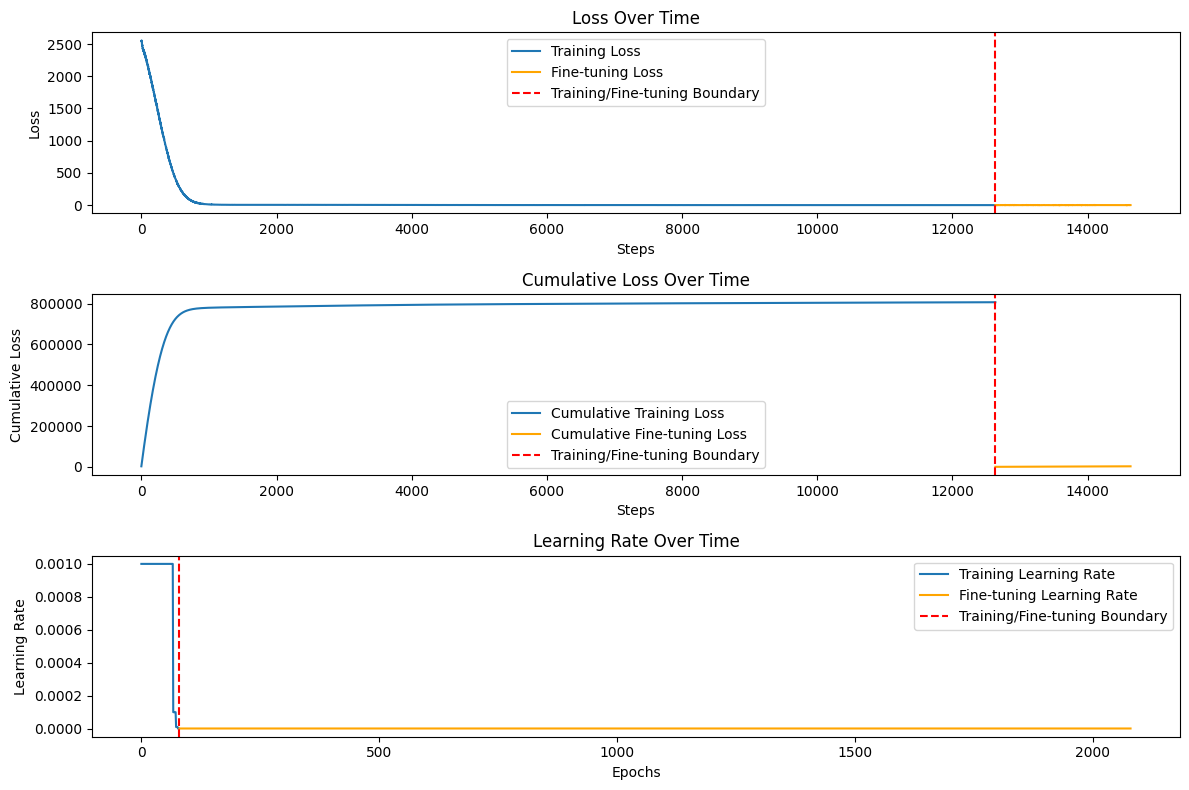

In [23]:
lstm_expert.plot_training_curves()  # 绘制训练曲线

Predicted values for t=50: [37.23289  45.872246 43.840794 41.886814 47.78604  53.644352 69.73913
 51.103424 50.947445 49.794388]
True values for t=50: [37.979206 46.101223 46.028137 41.439808 47.125584 51.89477  71.41243
 51.108482 51.90689  50.92283 ]


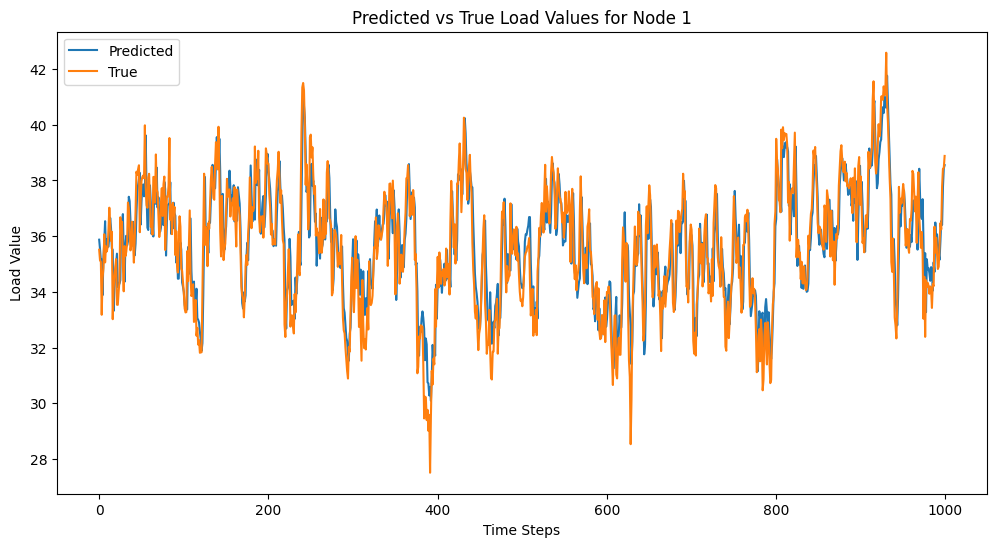

In [24]:
t = 50
predicted, true_value = lstm_expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
lstm_expert.plot_results(lstm_expert.predictions, lstm_expert.true_values)


In [10]:
gnn_expert = ModelExpert(config, data_manage, type='GNN')

In [11]:
%%time
gnn_expert.train()

device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  10%|█         | 10/100 [01:31<15:05, 10.06s/it]

Epoch [10/100], Ave_Loss: 1434.6208
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [03:13<13:37, 10.22s/it]

Epoch [20/100], Ave_Loss: 702.9402
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [05:07<13:21, 11.45s/it]

Epoch [30/100], Ave_Loss: 282.1971
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [07:08<12:00, 12.01s/it]

Epoch [40/100], Ave_Loss: 85.8496
Current Learning Rate: 0.001000


Training:  50%|█████     | 50/100 [08:49<08:22, 10.05s/it]

Epoch [50/100], Ave_Loss: 21.5059
Current Learning Rate: 0.001000


Training:  60%|██████    | 60/100 [10:28<06:31,  9.80s/it]

Epoch [60/100], Ave_Loss: 7.2285
Current Learning Rate: 0.001000


Training:  70%|███████   | 70/100 [12:09<05:04, 10.16s/it]

Epoch [70/100], Ave_Loss: 5.2848
Current Learning Rate: 0.001000


Training:  77%|███████▋  | 77/100 [13:30<04:02, 10.52s/it]

Early stopping triggered. Stopping training. Epoch: 78
Training finished after 78 epochs.
average loss pre epoch: 5.2450
CPU times: total: 29.8 s
Wall time: 13min 30s


In [12]:
%%time
gnn_expert.predict_and_fine_tune()  # 预测并微调

Predicting and Fine-tuning:  14%|█▍        | 140/1000 [00:00<00:04, 190.28it/s]

Step 100/1000, Loss: 5.1119
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  22%|██▏       | 223/1000 [00:01<00:03, 195.82it/s]

Step 200/1000, Loss: 5.3579
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  33%|███▎      | 326/1000 [00:01<00:03, 200.94it/s]

Step 300/1000, Loss: 5.3619
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  43%|████▎     | 429/1000 [00:02<00:02, 197.51it/s]

Step 400/1000, Loss: 5.3598
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  53%|█████▎    | 530/1000 [00:02<00:02, 193.30it/s]

Step 500/1000, Loss: 5.7109
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  63%|██████▎   | 631/1000 [00:03<00:01, 194.18it/s]

Step 600/1000, Loss: 5.5280
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  73%|███████▎  | 732/1000 [00:03<00:01, 194.47it/s]

Step 700/1000, Loss: 5.4588
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  83%|████████▎ | 833/1000 [00:04<00:00, 194.96it/s]

Step 800/1000, Loss: 5.3719
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  93%|█████████▎| 933/1000 [00:04<00:00, 192.39it/s]

Step 900/1000, Loss: 5.2833
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:05<00:00, 191.38it/s]

Step 1000/1000, Loss: 5.3411
Current Learning Rate: 0.000001
Average Fine-tuning Loss over 1000 steps: 5.3411
CPU times: total: 1.39 s
Wall time: 5.24 s


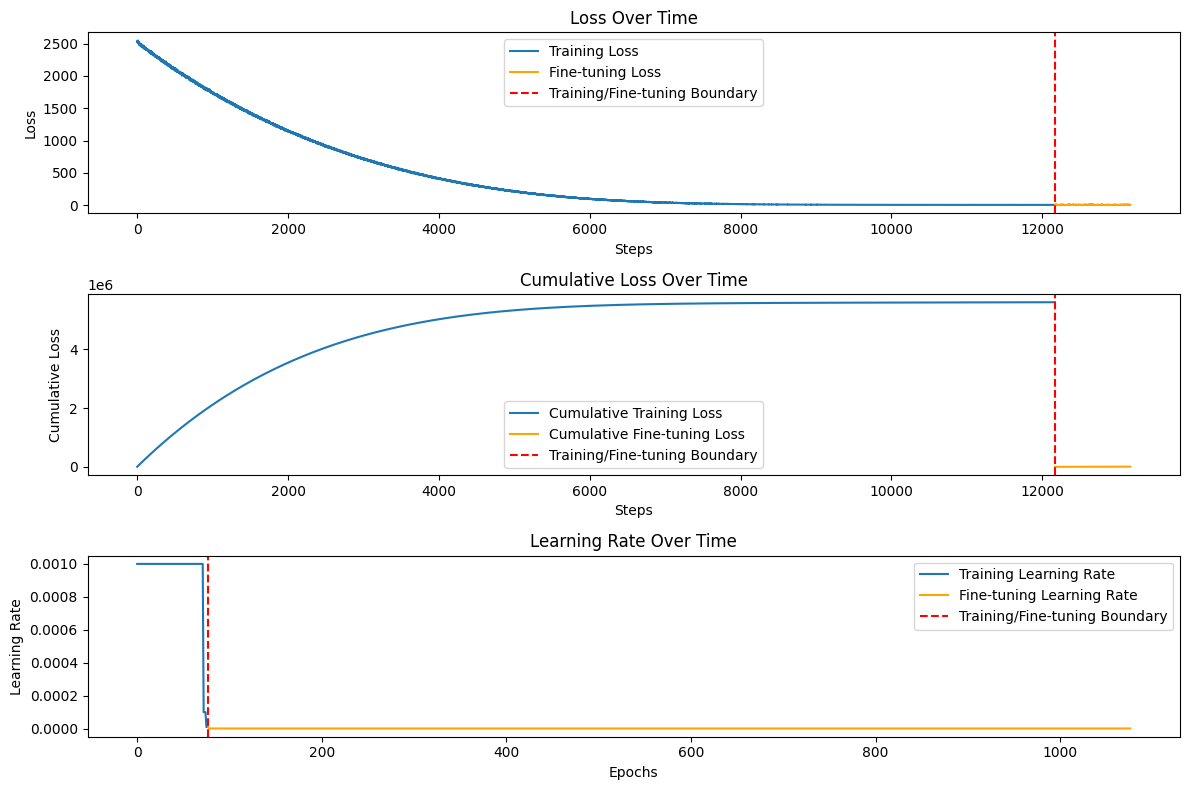

In [15]:
gnn_expert.plot_training_curves()  # 绘制训练曲线

Predicted values for t=50: [35.873867 45.74366  46.60917  42.04296  48.328518 54.117    68.652885
 51.74503  52.481586 49.253426]
True values for t=50: [37.979206 46.101223 46.028137 41.439808 47.125584 51.89477  71.41243
 51.108482 51.90689  50.92283 ]


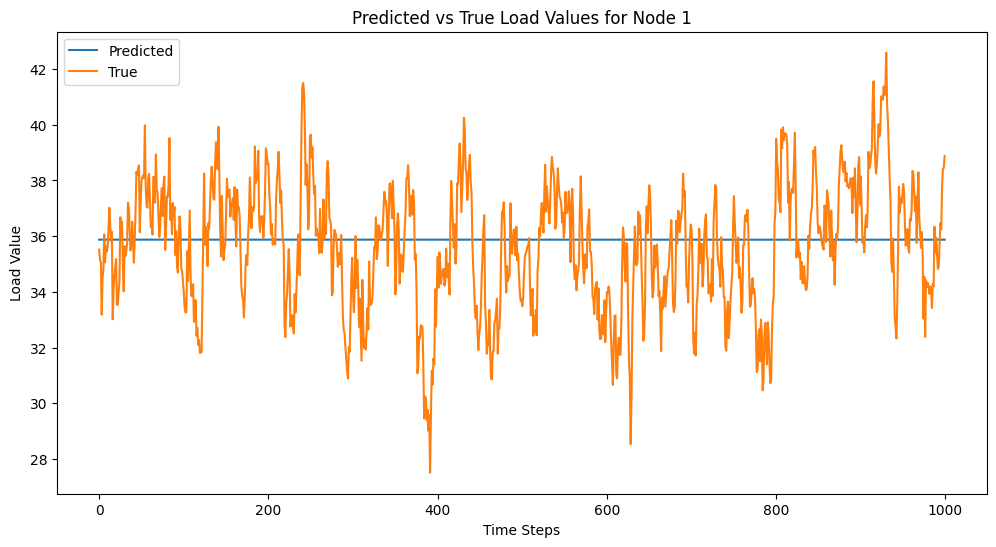

In [16]:
t = 50
predicted, true_value = gnn_expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
gnn_expert.plot_results(gnn_expert.predictions, gnn_expert.true_values)